<a href="https://colab.research.google.com/github/yuukiaaa/forextransformer/blob/main/ForexTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code uses forex data from Axiory.  This code assumes 1 miniute data which include date, open, high, low, close and volume.
If you need histrical data to try this code, visit following URL, download it, and put it in this colab files.
https://www.axiory.com/jp/trading-tools/historical-data
If you use GPU, please be sure Runtime type is checked for GPU.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import RootMeanSquaredError
import warnings
from typing import Tuple
from typing import List
from typing import Optional
import matplotlib.pyplot as plt

In [ ]:
# クラスの定義: 為替データを訓練用のデータに処理するためのクラス
class ForexData:
    def __init__(self, csvfile: str):
        self.df = pd.read_csv(csvfile)
        self.df.columns = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']
        self.df = self.df.dropna(subset=['date', 'time', 'open', 'high', 'low', 'close', 'volume'], how='any')
        self.X = self.df[['open', 'high', 'low', 'close']]
        self.y = self.df['close']
        self.X_mean, self.X_std = self.X.mean(), self.X.std()
        self.y_mean, self.y_std = self.y.mean(), self.y.std()
        self.X_train, self.y_train, self.X_test, self.y_test, self.X_train_mean, self.X_train_std, self.X_test_mean, self.X_test_std = None, None, None, None, None, None, None, None
        self.X_original, self.y_original, self.X_original_mean, self.X_original_std = None, None, None, None

    # 1分足の為替データからTransformerモデルの訓練に必要なデータセットを作成するメソッド
    # 引数"X"はself.X、引数"y"はself.yが入ることを想定
    @staticmethod
    def create_dataset(X: pd.DataFrame, y: pd.DataFrame, time_steps=5, shuffle=False) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        Xs, ys, Xs_mean, Xs_std = [], [], [], []

        # 以下Forループ内の処理は元データを引数"time_step"個毎のデータセットに分割し、正規化処理をしている
        # TODO: 精度を高めるためにさらなる検証・改善が必要
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)]
            w = y.iloc[i + time_steps]
            v_mean, v_std = v['close'].mean(), v['close'].std()

            if v_std == 0:
                v = v.applymap(lambda x: 0)
                v = v.values
                w = 0
            else:
                v = (v - v_mean) / v_std
                v = v.values
                w = (w - v_mean) / v_std

            Xs.append(v)
            ys.append(w)
            Xs_mean.append(v_mean)
            Xs_std.append(v_std)

            # 処理進捗状況の出力
            if (i+1) % 100 == 0:
                print(f"Processing dataset... {i+1}/{len(X) - time_steps}")

        Xs = np.array(Xs)
        ys = np.array(ys)
        Xs_mean = np.array(Xs_mean)
        Xs_std = np.array(Xs_std)

        # 学習データをシャッフルする場合の処理
        if shuffle:
            idx = np.random.permutation(len(Xs))
            Xs = Xs[idx]
            ys = ys[idx]
            Xs_mean = Xs_mean[idx]
            Xs_std = Xs_std[idx]

        return Xs, ys, Xs_mean, Xs_std

    def process_train_data(self, test_size=0.2, time_steps=5, shuffle_block=True):
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size, shuffle=False)
        self.X_train, self.y_train, self.X_train_mean, self.X_train_std = ForexData.create_dataset(X_train, y_train, time_steps=time_steps, shuffle=shuffle_block)
        self.X_test, self.y_test, self.X_test_mean, self.X_test_std = ForexData.create_dataset(X_test, y_test, time_steps=time_steps, shuffle=shuffle_block)

    def process_original_data(self, time_steps=5, shuffle_block=False):
        self.X_original, self.y_original, self.X_original_mean, self.X_original_std = ForexData.create_dataset(self.X, self.y, time_steps=time_steps, shuffle=shuffle_block)

    def get_train_test_sddata(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        return self.X_train, self.y_train, self.X_test, self.y_test, self.X_train_mean, self.X_train_std, self.X_test_mean, self.X_test_std

    def get_original_sddata(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        return self.X_original, self.y_original, self.X_original_mean, self.X_original_std

    def get_mean_std(self) -> Tuple[float, float, float, float]:
        return self.X_mean, self.X_std, self.y_mean, self.y_std

    def destandardize_data(self, y: np.ndarray, x_mean: np.ndarray, x_std: np.ndarray) -> np.ndarray:
        y = y * x_std + x_mean
        return y

In [ ]:
# クラスの定義: Transformerモデルの訓練や予測など各種メソッドを規定するクラス
class TransformerModel:
    def __init__(self, n_features=None, n_steps=None, n_outputs=None):
        self.n_features = n_features
        self.n_steps = n_steps
        self.n_outputs = n_outputs
        self.model = None
        self._strategy = None

    def _build_model(self):
        if self.n_features is None or self.n_steps is None or self.n_outputs is None:
            return None
        input_layer = tf.keras.layers.Input(shape=(self.n_steps, self.n_features))
        encoder_output = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=self.n_features, dropout=0.3)(input_layer, input_layer)
        encoder_output = tf.keras.layers.BatchNormalization()(encoder_output)
        encoder_output = tf.keras.layers.Dropout(0.3)(encoder_output)
        encoder_output = tf.keras.layers.Flatten()(encoder_output)
        encoder_output = tf.keras.layers.Dense(32, activation='relu')(encoder_output)
        output_layer = tf.keras.layers.Dense(self.n_outputs, activation='linear')(encoder_output)

        model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss='mse', optimizer='adam')
        self.model = model

    def _gpu_setting(self):
        if not self._strategy:
            gpus = tf.config.list_physical_devices('GPU')
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            self._strategy = tf.distribute.MirroredStrategy()
        else:
            pass

    def train(self, X_train, y_train, X_test, y_test, epochs=50, batch_size=64):
        self._build_model()
        self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

    def gpu_train(self, X_train, y_train, X_test, y_test, epochs=50, batch_size=64):
        try:
            self._gpu_setting()
            with self._strategy.scope():
                self._build_model()
                self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
        except RuntimeError as e:
            print(e)

    def predict(self, original_data):
        predict_data = self.model.predict(original_data).flatten()
        return predict_data

    def gpu_predict(self, original_data):
        try:
            print('before _gpu_setting()')
            self._gpu_setting()
            print('before strategy scope')
            with self._strategy.scope():
                print('before prediction')
                predict_data = self.model.predict(original_data).flatten()
                return predict_data
        except RuntimeError as e:
            print(e)


    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = load_model(path)

    @staticmethod
    def rmse(y_true: List[float], y_pred: List[float]) -> float:
        rmse = RootMeanSquaredError()
        rmse.update_state(y_true, y_pred)
        return rmse.result()

In [ ]:
# クラスの定義: ForexDataクラスとTransformerModelクラスを用いてユーザが実際に処理を行うクラス。
# クラスの目的: ユーザがシンプルな記述でcsvファイルからデータセットの分割、学習、予測、結果の描画までを行うことが目的
class ForexTransformerDirector:
    def __init__(self):
        self.data: Optional[ForexData] = None
        self.model: Optional[TransformerModel] = None
        self.X_data = None
        self.y_original = None
        self.y_pred = None

    def _create_data_instance(self, csvfile):
        self.data = ForexData(csvfile)

    def _create_model_instance(self, n_features=None, n_steps=None, n_outputs=None):
        self.model = TransformerModel(n_features, n_steps, n_outputs)

    def process_data(self, csvfile, test_size=0.2, time_steps=5):
        self._create_data_instance(csvfile)
        self.data.process_train_data(test_size=0.2, time_steps=time_steps, shuffle_block=True)
        self.data.process_original_data(time_steps=time_steps, shuffle_block=False)

    def train_model(self, epochs=50, batch_size=64, gpu=False):
        n_features = self.data.X_train.shape[2]
        n_steps = self.data.X_train.shape[1]
        n_outputs = 1

        self._create_model_instance(n_features, n_steps, n_outputs)
        if gpu is True:
            self.model.gpu_train(self.data.X_train, self.data.y_train, self.data.X_test, self.data.y_test, epochs=epochs, batch_size=batch_size)
        else:
            self.model.train(self.data.X_train, self.data.y_train, self.data.X_test, self.data.y_test, epochs=epochs, batch_size=batch_size)

    def predict(self, gpu=False):
        X_original = self.data.X_original
        y_original = self.data.y_original
        X_original_mean = self.data.X_original_mean
        X_original_std = self.data.X_original_std

        if gpu:
            y_pred = self.model.gpu_predict(X_original)
        else:
            y_pred = self.model.predict(X_original)

        y_original_ds = self.data.destandardize_data(y_original, X_original_mean, X_original_std)
        y_pred_ds = self.data.destandardize_data(y_pred, X_original_mean, X_original_std)

        self.y_original = y_original_ds
        self.y_pred = y_pred_ds

    def save_model(self, path):
        self.model.save(path)

    def load_model(self, path):
        self._create_model_instance()
        self.model.load(path)

    def get_data(self):
        return self.y_original, self.y_pred

    def plot(self, xlim: list=None):
        plt.plot(self.y_original, label='Original')
        plt.plot(self.y_pred, label='Predicted')

        if xlim:
            start_index = xlim[0]
            end_index = xlim[1]
            plt.xlim(start_index, end_index)  # X軸の範囲を指定
            plt.ylim(min(min(self.y_original[start_index:end_index]), min(self.y_pred[start_index:end_index])) - 0.5, max(max(self.y_original[start_index:end_index]), max(self.y_pred[start_index:end_index])) + 0.5)  # Y軸の範囲を自動調整

        plt.legend()
        plt.show()

    def rmse(self):
        return self.model.rmse(self.y_original, self.y_pred)


Please change "csvfile" name in the cell below to the file name you downloaded.

Processing dataset... 100/24029
Processing dataset... 200/24029
Processing dataset... 300/24029
Processing dataset... 400/24029
Processing dataset... 500/24029
Processing dataset... 600/24029
Processing dataset... 700/24029
Processing dataset... 800/24029
Processing dataset... 900/24029
Processing dataset... 1000/24029
Processing dataset... 1100/24029
Processing dataset... 1200/24029
Processing dataset... 1300/24029
Processing dataset... 1400/24029
Processing dataset... 1500/24029
Processing dataset... 1600/24029
Processing dataset... 1700/24029
Processing dataset... 1800/24029
Processing dataset... 1900/24029
Processing dataset... 2000/24029
Processing dataset... 2100/24029
Processing dataset... 2200/24029
Processing dataset... 2300/24029
Processing dataset... 2400/24029
Processing dataset... 2500/24029
Processing dataset... 2600/24029
Processing dataset... 2700/24029
Processing dataset... 2800/24029
Processing dataset... 2900/24029
Processing dataset... 3000/24029
Processing dataset.

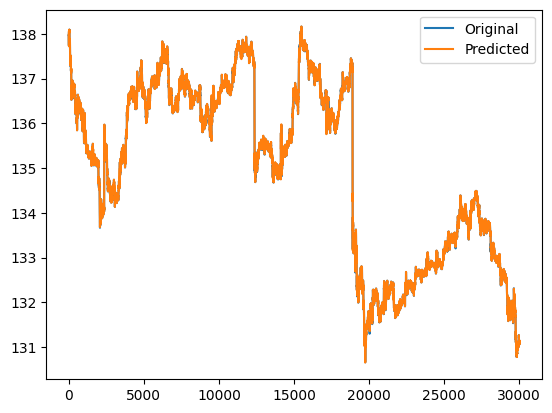

In [ ]:
ftd = ForexTransformerDirector()
ftd.process_data(csvfile="USDJPY_2022_12.csv", test_size=0.2, time_steps=5)
ftd.train_model(epochs=50, batch_size=64, gpu=True)
ftd.predict(gpu=True)
ftd.plot()

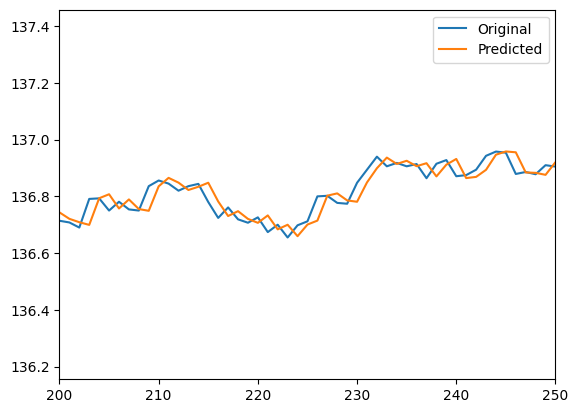

In [ ]:
# 上記を範囲を狭めてプロット表示
ftd.plot([200, 250])

In [ ]:
# 学習済みモデルの保存
ftd.save_model("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


If you would like to predict price movement using  another dataset using your trained model, please put the dataset in this colab files and execute the follwoing codes.

In [ ]:
ftd = ForexTransformerDirector()
ftd.process_data(csvfile="USDJPY_2022_12.csv", test_size=0.2, time_steps=5)
ftd.load_model("model.h5")
ftd.predict(gpu=True)

Processing dataset... 100/24029
Processing dataset... 200/24029
Processing dataset... 300/24029
Processing dataset... 400/24029
Processing dataset... 500/24029
Processing dataset... 600/24029
Processing dataset... 700/24029
Processing dataset... 800/24029
Processing dataset... 900/24029
Processing dataset... 1000/24029
Processing dataset... 1100/24029
Processing dataset... 1200/24029
Processing dataset... 1300/24029
Processing dataset... 1400/24029
Processing dataset... 1500/24029
Processing dataset... 1600/24029
Processing dataset... 1700/24029
Processing dataset... 1800/24029
Processing dataset... 1900/24029
Processing dataset... 2000/24029
Processing dataset... 2100/24029
Processing dataset... 2200/24029
Processing dataset... 2300/24029
Processing dataset... 2400/24029
Processing dataset... 2500/24029
Processing dataset... 2600/24029
Processing dataset... 2700/24029
Processing dataset... 2800/24029
Processing dataset... 2900/24029
Processing dataset... 3000/24029
Processing dataset.

In [ ]:
ftd.predict(gpu=True)

before _gpu_setting()
before strategy scope
before prediction
939/939 [==============================] - 3s 3ms/step


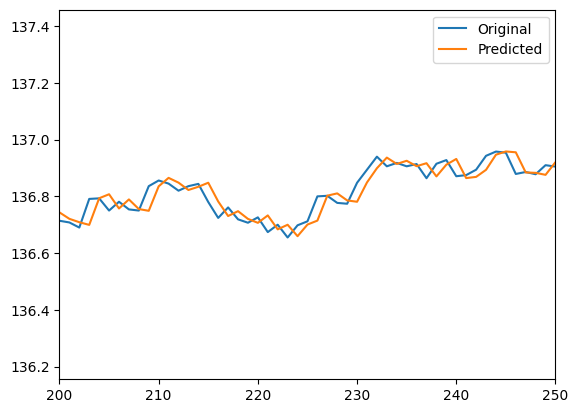

In [ ]:
ftd.plot([200, 250])